# **Wildfire Image Detection Dissertation Processing File**

## Importing our modules and libraries



In [2]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image
import os
import cv2
import matplotlib.image as mpimg
import random
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import shutil
from skimage import io, transform
import time
import flask

%matplotlib inline

In [3]:
DATASET_REPO_DIR = os.getcwd()

In [4]:
print(DATASET_REPO_DIR)

C:\Users\koray\Downloads\Dissertation_Archive


## Pre-processing our dataset

In [5]:
def select_random_images(folder, num_images):
    all_images = os.listdir(folder)
    selected_images = random.sample(all_images, num_images)
    return selected_images

num_images = 10 # Number of images you want to select
train_fire_images = select_random_images(DATASET_REPO_DIR+"/main_dataset/train_fire", num_images)
train_smoke_images = select_random_images(DATASET_REPO_DIR+"/main_dataset/train_smoke", num_images)
train_nofire_nosmoke_images = select_random_images(DATASET_REPO_DIR+"/main_dataset/train_nofire_nosmoke", num_images)

In [6]:
# Checking our images have loaded into the array correctly

print(len(train_fire_images))
print(len(train_smoke_images))
print(len(train_nofire_nosmoke_images))

train_fire_images[:10]

10
10
10


['FIRE (1407).jpg',
 'FIRE (1766).jpg',
 'FIRE (233).png',
 'FIRE (837).jpg',
 'FIRE (346).jpg',
 'FIRE (26).jpg',
 '05236.jpg',
 'FIRE (1324).jpg',
 'FIRE (122).png',
 'FIRE (565).png']

In [7]:
# Here a size check of a random is done to see how we need to resize these images during the pre-processing

# Example image path
image_path = os.path.join(DATASET_REPO_DIR+"/main_dataset/train_fire", train_fire_images[2])

# Read the image
img = io.imread(image_path)
img_shape = img.shape
print(img_shape)

(619, 1100, 3)


In [8]:
# Here the pre-process happens along with a visual count to see how the progression of the pre-processing is going

def preprocess_images(images, folder, size=(124, 124, 3), padding=2):
    processed_images = []
    count = 0
    start_time = time.time()
    for image in images:
        img = io.imread(os.path.join(folder, image))
        img = img.astype(float)
        img = img.astype(float) / 255.0
        img = transform.resize(img, size)
        img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), 'constant')
        processed_images.append(img)
        count += 1
        #print(f"Processed {count} images.")
    end_time = time.time()
    print(f"Processed {count} images in {end_time - start_time:.2f} seconds.")
    return np.array(processed_images)

preprocessed_train_fire_images = preprocess_images(train_fire_images, DATASET_REPO_DIR+"/main_dataset/train_fire") 
preprocessed_train_smoke_images = preprocess_images(train_smoke_images, DATASET_REPO_DIR+"/main_dataset/train_smoke")
preprocessed_train_nofire_nosmoke_images = preprocess_images(train_nofire_nosmoke_images, DATASET_REPO_DIR+"/main_dataset/train_nofire_nosmoke")

Processed 10 images in 17.56 seconds.
Processed 10 images in 4.99 seconds.
Processed 10 images in 0.85 seconds.


In [9]:
preprocessed_train_smoke_images[1].shape

(128, 128, 3)

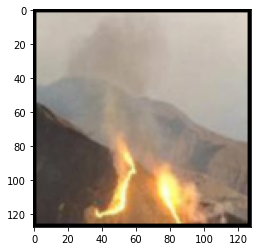

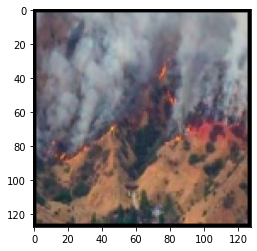

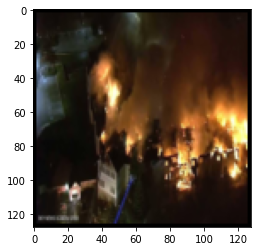

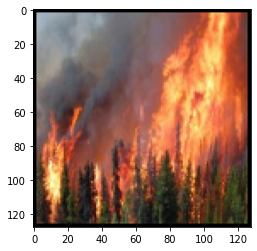

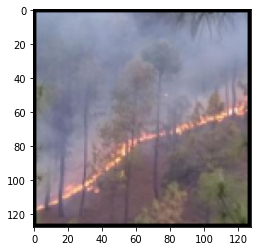

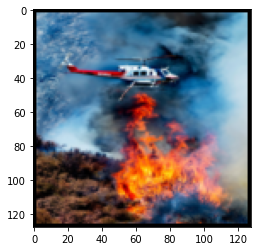

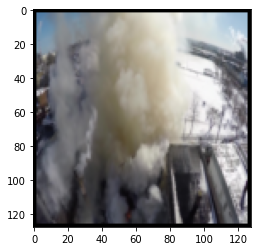

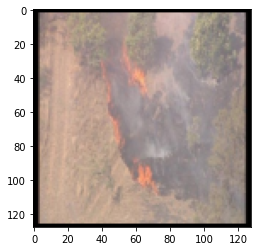

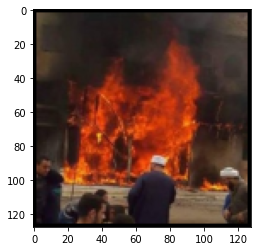

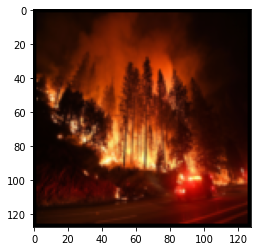

In [10]:
for image in preprocessed_train_fire_images[:10]:
    plt.imshow(image)
    plt.show()

**Saving the pre-processed images to new directories**

The reasoning behind the saving of these images into new directories is because of the limited GPU access that jupyter notebook on my home laptop presents. These saved folders will then be used in Google Colab. The pre-processing on Jupyter notebook is noticeably quicker than on Google Colab.

In [11]:
# Save preprocessed images to new directories
os.makedirs(DATASET_REPO_DIR+"preprocessed_dataset", exist_ok=True)
os.makedirs(DATASET_REPO_DIR+"preprocessed_dataset/train_fire", exist_ok=True)
os.makedirs(DATASET_REPO_DIR+"preprocessed_dataset/train_smoke", exist_ok=True)
os.makedirs(DATASET_REPO_DIR+"preprocessed_dataset/train_nofire_nosmoke", exist_ok=True)

In [12]:
import warnings

# Suppress the "Lossy conversion from float64 to uint8" warning
warnings.filterwarnings("ignore", message="Lossy conversion from float64 to uint8.")

def save_preprocessed_images(preprocessed_images, folder):
    os.makedirs(folder, exist_ok=True)
    for i, image in enumerate(preprocessed_images):
        io.imsave(f"{folder}/{i}.jpg", image)

In [13]:
import warnings

# Suppress the "Lossy conversion from float64 to uint8" warning
warnings.filterwarnings("ignore", message="Lossy conversion from float64 to uint8.")

# Saving the pre-processed images
save_preprocessed_images(preprocessed_train_fire_images, DATASET_REPO_DIR+"preprocessed_dataset/train_fire")
save_preprocessed_images(preprocessed_train_smoke_images, DATASET_REPO_DIR+"preprocessed_dataset/train_smoke")
save_preprocessed_images(preprocessed_train_nofire_nosmoke_images, DATASET_REPO_DIR+"preprocessed_dataset/train_nofire_nosmoke")

warnings.filterwarnings("ignore", message="Lossy conversion from float64 to uint8.")
warnings.filterwarnings(""*)

SyntaxError: invalid syntax (<ipython-input-13-bd89e8a43315>, line 12)

In [18]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Dissertation_Wildfire_Detection_Jupyter.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/

no changes added to commit (use "git add" and/or "git commit -a")


In [53]:
!git add .

In [54]:
!git commit -m "Preprocessed Dataset Test"

On branch feature/preprocessed-images
nothing to commit, working tree clean


In [56]:
!git push

branch 'feature/preprocessed-images' set up to track 'origin/feature/preprocessed-images'.


remote: 
remote: Create a pull request for 'feature/preprocessed-images' on GitHub by visiting:        
remote:      https://github.com/KoraySali/Dissertation_Archive/pull/new/feature/preprocessed-images        
remote: 
To https://github.com/KoraySali/Dissertation_Archive.git
 * [new branch]      feature/preprocessed-images -> feature/preprocessed-images


**Hot-encoding the labels into respective classes**

In [8]:
# Encoding the labels
train_fire_labels = [0 for i in range(len(preprocessed_train_fire_images))]
train_smoke_labels = [1 for i in range(len(preprocessed_train_smoke_images))]
train_nofire_nosmoke_labels = [2 for i in range(len(preprocessed_train_nofire_nosmoke_images))]

# One-hot encoding the labels using keras library
train_fire_labels = tf.keras.utils.to_categorical(train_fire_labels, num_classes=3)
train_smoke_labels =  tf.keras.utils.to_categorical(train_smoke_labels, num_classes=3)
train_nofire_nosmoke_labels =  tf.keras.utils.to_categorical(train_nofire_nosmoke_labels, num_classes=3)

In [9]:
# Checking the classes match the labels here

train_smoke_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

## Training and testing split for our model to use

This is slightly redundant as we do this in our Google Colaboratory file so when running this code skip this as there becomes no need.

In [10]:
#----------------------------------------------SKIP THIS CODE SECTION-----------------------------------------------------------

In [11]:
# Combining the preprocessed images and their labels
X_train = np.concatenate([preprocessed_train_fire_images, preprocessed_train_smoke_images, preprocessed_train_nofire_nosmoke_images])
y_train = np.concatenate([train_fire_labels, train_smoke_labels, train_nofire_nosmoke_labels])

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (48, 128, 128, 3)
Train labels shape:  (48, 3) float32
Test data shape:  (12, 128, 128, 3)
Test labels shape:  (12, 3)


In [13]:
mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel

In [14]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (48, 128, 128, 3)
Train labels shape:  (48, 3) float32
Test data shape:  (12, 128, 128, 3)
Test labels shape:  (12, 3)


## Model Creation

This model is created for casual use and testing the true/complete model will be made in our Google Colab ipynb file and saved as .h5 file.

In [15]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [16]:
# Data Augmentation to feed the model with more imagery

In [17]:
test_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[128,128,3]),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [18]:
test_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_test = test_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
2/2 [==============================] - 1s 356ms/step - loss: 4.3074 - accuracy: 0.2292 - val_loss: 16.1867 - val_accuracy: 0.1667
Epoch 2/10
2/2 [==============================] - 0s 179ms/step - loss: 8.9102 - accuracy: 0.3750 - val_loss: 2.6011 - val_accuracy: 0.5833
Epoch 3/10
2/2 [==============================] - 0s 173ms/step - loss: 1.6830 - accuracy: 0.6667 - val_loss: 0.6322 - val_accuracy: 0.7500
Epoch 4/10
2/2 [==============================] - 0s 182ms/step - loss: 1.0188 - accuracy: 0.5833 - val_loss: 0.5343 - val_accuracy: 0.7500
Epoch 5/10
2/2 [==============================] - 0s 182ms/step - loss: 0.8071 - accuracy: 0.7500 - val_loss: 0.7136 - val_accuracy: 0.6667
Epoch 6/10
2/2 [==============================] - 0s 183ms/step - loss: 0.5674 - accuracy: 0.7708 - val_loss: 0.6401 - val_accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 0s 168ms/step - loss: 0.3773 - accuracy: 0.7917 - val_loss: 0.7342 - val_accuracy: 0.6667
Epoch 8/10
2/2 [===

In [30]:
# Save model
from tensorflow.keras.models import save_model
save_model(test_model, 'test_cnn.h5')

## Pre-trained Model for Comparison

## Model Performance Analysis

In [19]:
class_names = ['fire', 'smoke', 'no_fire_no_smoke']

In [20]:
predicted_classes  = np.argmax(test_model.predict(X_test.reshape(-1,128,128,3)), axis=-1)
y_true=y_test

In [21]:
y_true = np.argmax(y_test, axis=-1)
correct = np.nonzero(predicted_classes == y_true)[0]
incorrect = np.nonzero(predicted_classes != y_true)[0]

print("Correctly predicted classes:",correct.shape[0])
print("Incorrectly predicted classes:",incorrect.shape[0])

Correctly predicted classes: 8
Incorrectly predicted classes: 4


### Plotting the train and test imagery

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


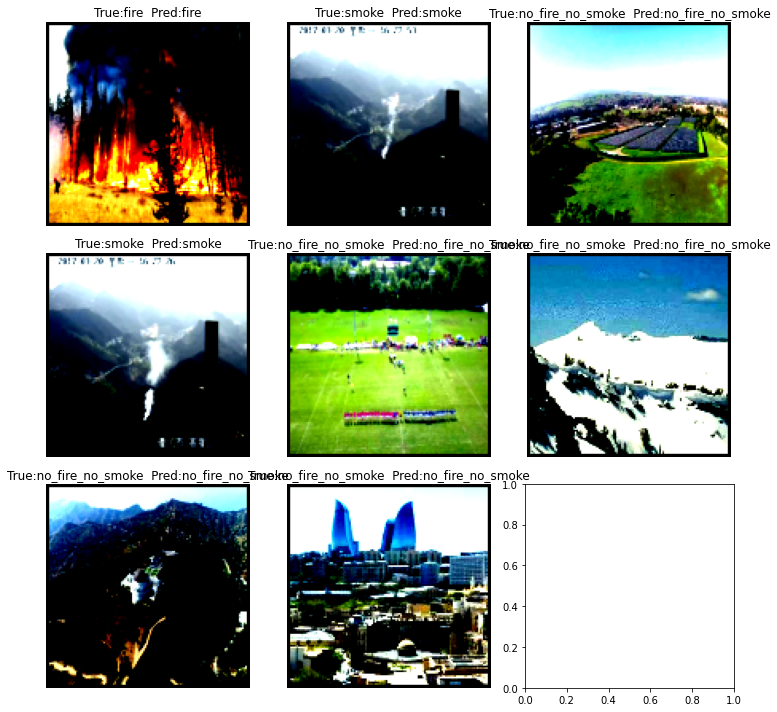

In [52]:
## Plotting the train and test imagery

def plot_plain_images(data_index):
    f, ax = plt.subplots(3, 3, figsize=(10,10))

    for i, indx in enumerate(data_index[:9]):
        predicted_class = class_names[predicted_classes[indx]]
        true_class = class_names[y_true[indx]]
        ax[i//3, i%3].imshow(X_test[indx].reshape(128, 128, 3), cmap='gray')
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title("True:{}  Pred:{}".format(true_class, predicted_class))

    f.tight_layout()
    plt.show()   

plot_plain_images(correct[:10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


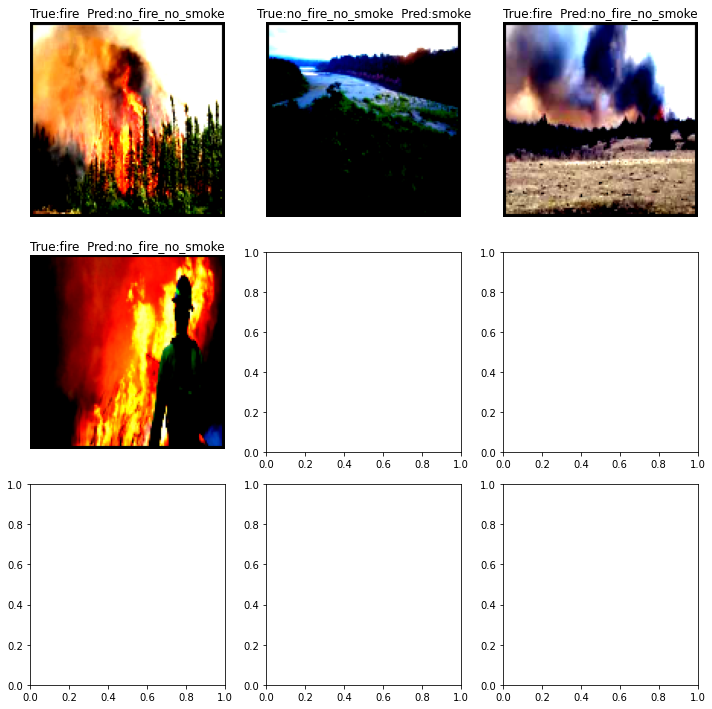

In [53]:
plot_plain_images(incorrect)

In [59]:
for idx in correct[:10]:
    img = X_test[idx]
    label = y_test[idx]

    # Get the model's prediction and its confidence score
    pred = test_model.predict(np.expand_dims(img, axis=0))[0]
    pred_index = np.argmax(pred)

    # Find the coordinates of the highest activation pixel
    coord = np.unravel_index(np.argmax(pred), pred.shape)
    x, y = coord[0], coord[1]

    # Plot the image and print the coordinates of the highest activation pixel
    #plot_images([idx], model)
    print(f"Coordinates: ({x}, {y})")


IndexError: tuple index out of range

In [24]:
#-------------------------------------------------SKIP UNTIL THIS POINT--------------------------------------------------------

## Predicting images from computer camera imagery

This step takes snapshots of the live feed, pre-processes and predicts the feed as images rather than a whole/live video feed.

In [ ]:
# Model h5 import from colab


In [29]:
frame_folder = "/Users/koray/Downloads/Artefact/main_dataset/camera_snapshots"
os.mkdir(frame_folder)

In [30]:
# We want to find out the frames per second in order to set a capture for the number of frames we want in a particular length of time
framecap = cv2.VideoCapture(0)
fps = framecap.get(cv2.CAP_PROP_FPS)
print(fps, 'fps')

30.0 fps


In [31]:
frame_count = 0
frame, img = framecap.read()

while frame == True:
    frame, img = framecap.read()
    print('Frame has been saved...', frame)
    
    if not frame:
        print('Frame save has been saved...', frame)
        break
        
    cv2.imwrite(os.path.join(frame_folder, "Computer Frame Image {:d}.jpg".format(frame_count)), img)
    
    # This can be changed to give a different frame number saved, e.g. 10 = every 10th frame
    num_frame = 10
    frame_count = frame_count + num_frame
    
    # This number can be changed dependent on how many frame captures you want saved, e.g. 50 = up to a total of 50 frames
    if frame_count == 50:
        break

Frame has been saved... True
Frame has been saved... True
Frame has been saved... True
Frame has been saved... True
Frame has been saved... True


### Pre-processing captured camera images

In [32]:
def select_images_in_folder(folder):
    all_images = os.listdir(folder)
    return all_images

In [33]:
test_capture_images = select_images_in_folder("/Users/koray/Downloads/Artefact/main_dataset/camera_snapshots")

In [34]:
test_capture_images

['Computer Frame Image 0.jpg',
 'Computer Frame Image 10.jpg',
 'Computer Frame Image 20.jpg',
 'Computer Frame Image 30.jpg',
 'Computer Frame Image 40.jpg']

In [35]:
preprocessed_capture_images = preprocess_images(test_capture_images, "/Users/koray/Downloads/Artefact/main_dataset/camera_snapshots")

Processed 5 images in 0.48 seconds.


### Predicting the capture images using the trained CNN model

Here we take the imported and GPU trained model using the h5 file from our google colaboratory ipynb file.

In [36]:
# ADD MODEL .h5 FILE HERE

In [37]:
predicted_labels = []
for image in preprocessed_capture_images:
    prediction = test_model.predict(np.expand_dims(image, axis=0))[0]
    predicted_label = np.argmax(prediction)
    predicted_labels.append(predicted_label)

In [38]:
label_strings = ['Fire', 'Smoke', 'No Fire/Smoke']
predicted_label_strings = [label_strings[label] for label in predicted_labels]

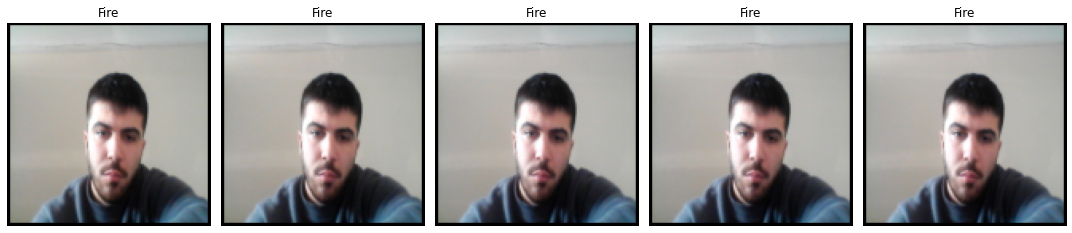

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=len(preprocessed_capture_images), figsize=(15, 8))

for i, ax in enumerate(axes):
    ax.imshow(preprocessed_capture_images[i])
    ax.set_title(predicted_label_strings[i])
    ax.axis('off')

plt.tight_layout()
plt.show()